In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale

from tile_units import TileUnit
from tile_units import TileShape
from tile_map import Tiling

#### **LOL** I renamed your file to something more manageable...
and added an ID column (so grab the one in the repo)

Note: this data run was originally 000208 from \data\ag-covid\paper-GWR-OLS

In [2]:
gwr = gpd.read_file("../data/lukes-gwr.gpkg").to_crs(5070)

# GWR example
## Make a H3 tile unit
First set the spacing (this is across the 7 hexes) and in whatever units the projection uses.

In [3]:
d = 50000


Make an empty tile unit we can overwrite with hand-made elements 

In [4]:
tile_unit = TileUnit(spacing = d, crs = gwr.crs, tile_shape = TileShape.HEXAGON)

In [5]:
# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

# inset scaling
sf2 = 0.9

hex = scale(tile_unit.tile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners[:-1]]
hexes = gpd.GeoSeries(hexes, crs = gwr.crs).rotate(
    rotation, origin = (0, 0)).scale(sf2, sf2, origin = (0, 0))

tile_unit.elements = gpd.GeoDataFrame(
    data = {"element_id": list("abcdefg")}, crs = gwr.crs,
    geometry = hexes
)

Note that "a" is the centre one.

<AxesSubplot:>

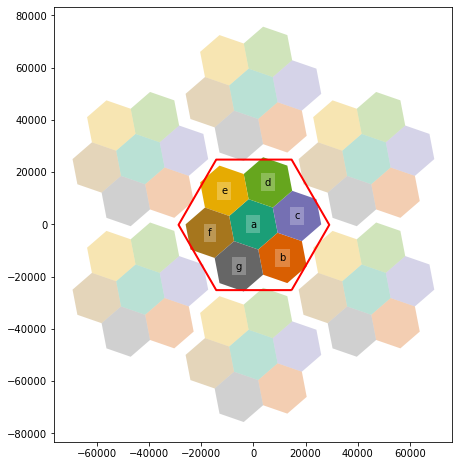

In [6]:
tile_unit.plot(r = 1)

## Tile a map

In [7]:
tiling = Tiling(tile_unit, gwr, id_var = "ID")
h3_map = tiling.get_tiled_map(prioritise_tiles = True)

## And make a map

But... we need to make a custom colour ramp and what not... I am not confident that this is maintaining repeatable ordering between the tiles relative to the categorical variable. You will know your data better than me and might be able to tell. I'm also not sure if the order is as we would like.

### Grey for insignificant

In [8]:
ids = list("bcdeafg")  # by inspection to get ordering desired
betas = [n for n in gwr.columns if "_beta_classified" in n]
h3_map.variables = dict(zip(ids, betas))
h3_map.colourmaps =  dict(zip(
    betas, 7 * [{'associated with LESS covid': "#69A7CF",
                 'not significant': "#C7C7C7",
                 'associated with MORE covid': "#EF8A62"}]))

(<AxesSubplot:>, <Axes:label='inset_axes'>)

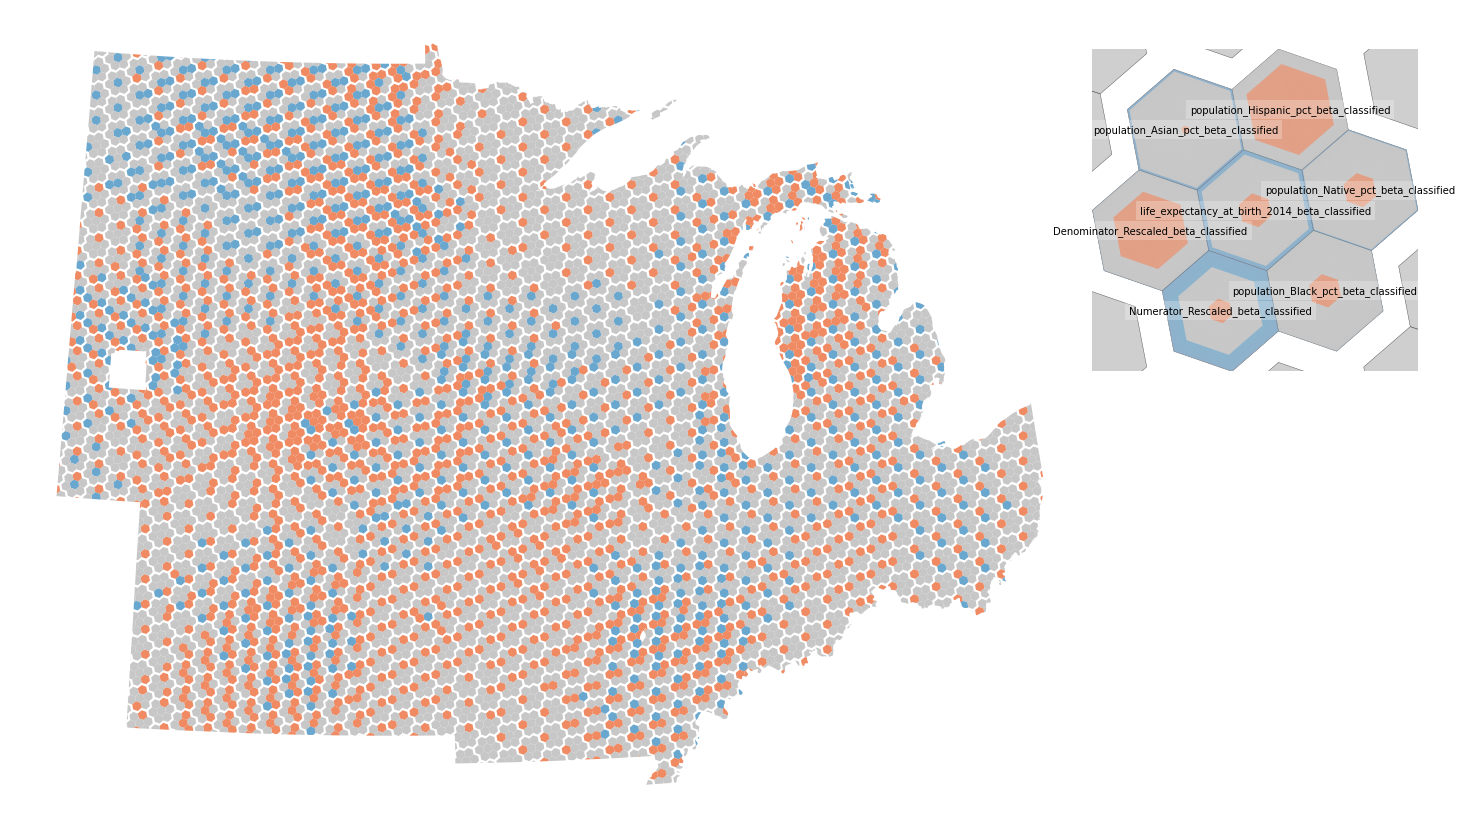

In [9]:
h3_map.render()

## A woven alternative

<AxesSubplot:>

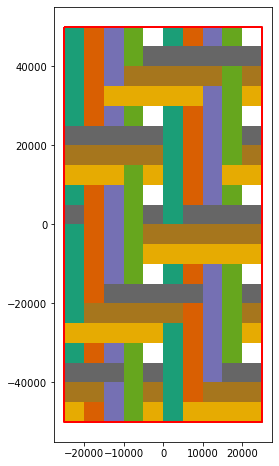

In [10]:
from weave_units import WeaveUnit

w = WeaveUnit(strands = "abcd-|efg-", weave_type = "twill", n = 5,
              aspect = 1, spacing = 5000, crs = gwr.crs)

w.plot(show_ids = False)

In [15]:
w_tiling = Tiling(w, gwr, id_var = "ID")

In [16]:
w_map = w_tiling.get_tiled_map(rotation = 30, prioritise_tiles = True)

(<AxesSubplot:>, <Axes:label='inset_axes'>)

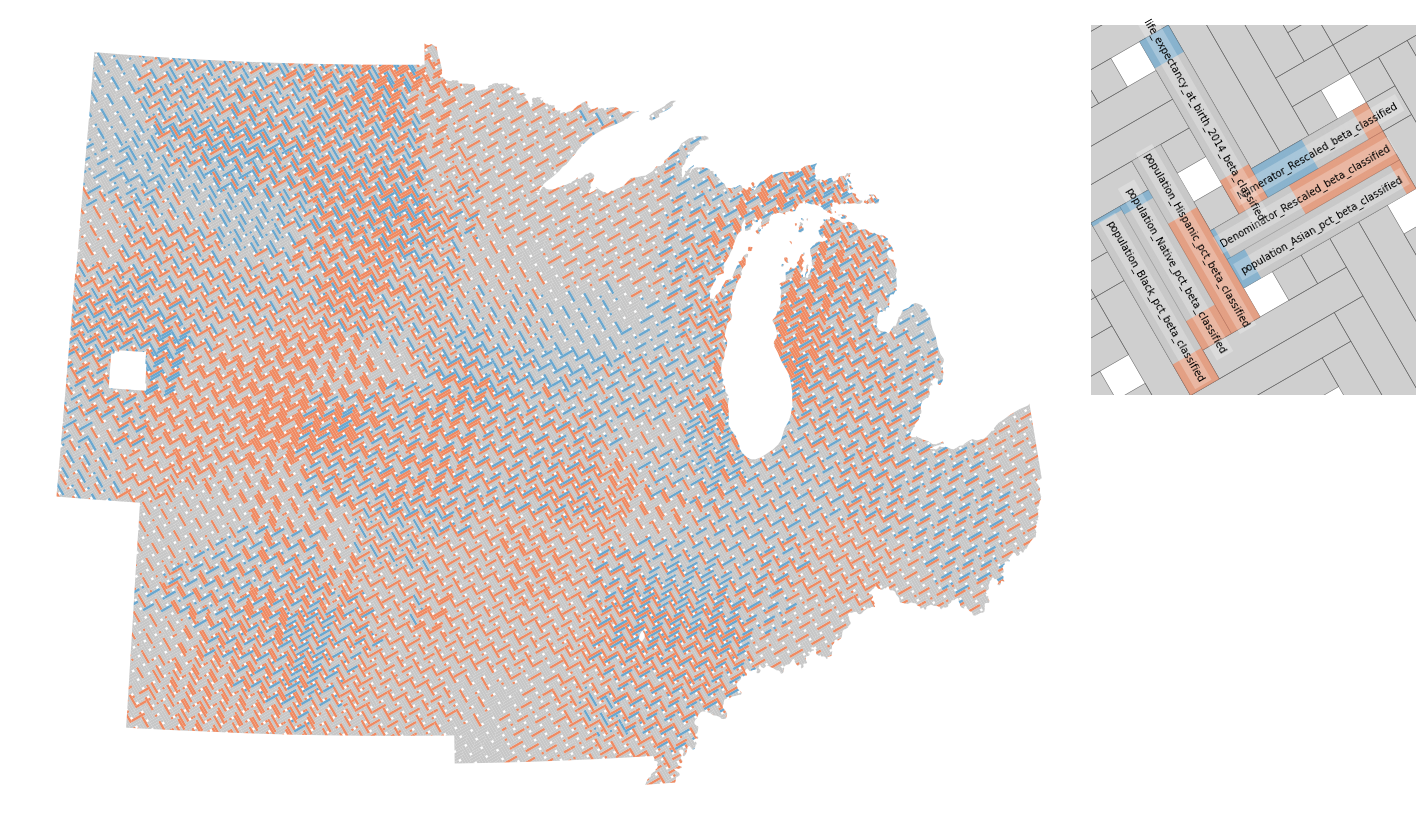

In [17]:
w_map.variables = h3_map.variables
w_map.colourmaps = h3_map.colourmaps
w_map.render()